# Medicaid fraudulent claims

https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/DE_Syn_PUF.html

Unfortunately, synthetic use medicare files are only available for 2008-2010... only provider information is available for 2010 + (see other notebook).... This is a set of 5% of random sampling of data from this time frame, and is broken into 20 seconds. To start, just bring in one of the claims samples.

The Basics:

Every claim (visit, drug, procedure, diagnosis) consists of a code, which is pre-negotiated

Example of fraud: "accidentally" adding an extra service

Goal: build a model of "normal" claims, based on things that normally go together (e.g. a cast with an x-ray)

Slightly more technical: 
- consider each claim as a cluster of codes
- treat the co-occurance of terms in a claim as their similarity
- we can think of the average distance between the terms as 1 / similarity
- extrapolating to a cluster, compute the average diameter of the cluster (square root of the sum of squared distances of all codes)

Other literature:

- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4796421/
- http://blog.operasolutions.com/bid/388511/data-science-as-the-panacea-for-healthcare-fraud-waste-and-abuse

Let's set if it makes sense...

In [2]:
import itertools
import numpy as np
import os.path
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

folder = os.getcwd()

# extract codes as bag of codes from input
outpatient_df = pd.read_csv(os.path.join(folder, "..", "DE1_0_2008_to_2010_Outpatient_Claims_Sample_1.csv"), low_memory=False)
outpatient_df.head()

,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,...,HCPCS_CD_36,HCPCS_CD_37,HCPCS_CD_38,HCPCS_CD_39,HCPCS_CD_40,HCPCS_CD_41,HCPCS_CD_42,HCPCS_CD_43,HCPCS_CD_44,HCPCS_CD_45
0,00013D2EFD8E45D1,542192281063886,1,20080904.0,20080904.0,2600RA,50.0,0.0,4.824842e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00016F745862898F,542272281166593,1,20090602.0,20090602.0,3901GS,30.0,0.0,2.963420e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00016F745862898F,542282281644416,1,20090623.0,20090623.0,3939PG,30.0,0.0,5.737808e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0001FDD721E223DC,542642281250669,1,20091011.0,20091011.0,3902NU,30.0,0.0,1.233848e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00024B3D2352D2D0,542242281386963,1,20080712.0,20080712.0,5200TV,30.0,0.0,9.688809e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
outpatient_df.shape

(790790, 76)

In [3]:
outpatient_df.columns

Index([u'DESYNPUF_ID', u'CLM_ID', u'SEGMENT', u'CLM_FROM_DT', u'CLM_THRU_DT',
       u'PRVDR_NUM', u'CLM_PMT_AMT', u'NCH_PRMRY_PYR_CLM_PD_AMT',
       u'AT_PHYSN_NPI', u'OP_PHYSN_NPI', u'OT_PHYSN_NPI',
       u'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', u'ICD9_DGNS_CD_1', u'ICD9_DGNS_CD_2',
       u'ICD9_DGNS_CD_3', u'ICD9_DGNS_CD_4', u'ICD9_DGNS_CD_5',
       u'ICD9_DGNS_CD_6', u'ICD9_DGNS_CD_7', u'ICD9_DGNS_CD_8',
       u'ICD9_DGNS_CD_9', u'ICD9_DGNS_CD_10', u'ICD9_PRCDR_CD_1',
       u'ICD9_PRCDR_CD_2', u'ICD9_PRCDR_CD_3', u'ICD9_PRCDR_CD_4',
       u'ICD9_PRCDR_CD_5', u'ICD9_PRCDR_CD_6', u'NCH_BENE_PTB_DDCTBL_AMT',
       u'NCH_BENE_PTB_COINSRNC_AMT', u'ADMTNG_ICD9_DGNS_CD', u'HCPCS_CD_1',
       u'HCPCS_CD_2', u'HCPCS_CD_3', u'HCPCS_CD_4', u'HCPCS_CD_5',
       u'HCPCS_CD_6', u'HCPCS_CD_7', u'HCPCS_CD_8', u'HCPCS_CD_9',
       u'HCPCS_CD_10', u'HCPCS_CD_11', u'HCPCS_CD_12', u'HCPCS_CD_13',
       u'HCPCS_CD_14', u'HCPCS_CD_15', u'HCPCS_CD_16', u'HCPCS_CD_17',
       u'HCPCS_CD_18', u'HCPCS

In [14]:
# create a series codebag which joins all the codes into a string for a given visit

def join_codes(row):
    return " ".join([str(v) for i, v in row.iteritems() if pd.notnull(v)])

# all the code columns have _CD_ in them

colnames = [colname for colname in outpatient_df.columns if "_CD_" in colname]
codebag = outpatient_df.ix[:, colnames].apply(join_codes, axis=1)
codebag.head()

0                                    V5841 85610 84153
1    V5832 V5861 2724 3182 V5869 42731 85610 80048 ...
2                    9594 E9174 4019 71101 78480 94060
3                              78943 V5866 V1272 36415
4                                     6009 76872 82365
dtype: object

In [5]:
codebag.isnull().sum()

0

In [17]:
# use the codes to build a sparse matrix
# essentially, convert collection of text documents to a matrix of token counts
vec = CountVectorizer(min_df=1, binary=True)
X = vec.fit_transform(codebag)

X.shape

(790790, 17023)

In [18]:
# this is the sort of data we will use

# first row
[code for code in X[1, :].nonzero()][1]

array([11823, 16611, 16619,  2667,  3689, 16626,  5497, 10524, 10534,
       11112, 13625, 12103, 11642, 10543, 11480], dtype=int32)

In [19]:
# sanity check

import scipy.sparse as sps

sps.issparse(X)

True

In [20]:
# so, we can compute the similarities by multiplying by the transpose, giving us a 17023 ^ 2 matrix
# the similarity is the number of times the terms co-occur in a claim (document)
# we can use the similarity to compute an average distance

similarity = X.T * X
similarity.shape

(17023, 17023)

In [21]:
similarity.getrow(1).todense()[:, 1]

matrix([[2]])

In [23]:
# now, use the similarities to determine the consistency of codes within a claim
# to do this, compute the average diameter of all codes in the claim (square root of sum of squares)

# generates a file with a series of numbers, where each number is the cluster diameter for a single claim
# creates a univariate distribution, so it is easy to find outliers

# THIS IS SLOW
# there is probably a much faster way to compute this...

import gc

EPSILON = 0.001

fileout = open(os.path.join(folder, "..", "clusters-processed.txt"), 'wb')

similarity_dense = similarity.todense()

for row in range(0, X.shape[0]):
    # manual garbage collection
    if row % 1000 == 0:
        print("row " + str(row))
        gc.collect()
    # get non-zero codes in the row from our CountVectorizer matrix
    codes = [code for code in X[row, :].nonzero()][1]
    dists = []
    for i, j in itertools.product(codes, codes):
        # only take thhe upper triangle
        if i < j:
            sim_ij = similarity_dense[i][:, j][0]
            if sim_ij == 0:
                sim_ij = EPSILON
            dists.append(1 / (sim_ij ** 2)) 
    fileout.write("%f\n" % (np.sqrt(sum(dists)) / len(dists)))

fileout.close()

row 0


/Users/maxwellbates/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in double_scalars


row 1000
row 2000
row 3000
row 4000
row 5000
row 6000
row 7000
row 8000
row 9000
row 10000
row 11000
row 12000
row 13000
row 14000
row 15000
row 16000
row 17000
row 18000
row 19000
row 20000
row 21000
row 22000
row 23000
row 24000
row 25000
row 26000
row 27000
row 28000
row 29000
row 30000
row 31000
row 32000
row 33000
row 34000
row 35000
row 36000
row 37000
row 38000
row 39000
row 40000
row 41000
row 42000
row 43000
row 44000
row 45000
row 46000
row 47000
row 48000
row 49000
row 50000
row 51000
row 52000
row 53000
row 54000
row 55000
row 56000
row 57000
row 58000
row 59000
row 60000
row 61000
row 62000
row 63000
row 64000
row 65000
row 66000
row 67000
row 68000
row 69000
row 70000
row 71000
row 72000
row 73000
row 74000
row 75000
row 76000
row 77000
row 78000
row 79000
row 80000
row 81000
row 82000
row 83000
row 84000
row 85000
row 86000
row 87000
row 88000
row 89000
row 90000
row 91000
row 92000
row 93000
row 94000
row 95000
row 96000
row 97000
row 98000
row 99000
row 100000
row 1010

KeyboardInterrupt: 

In [24]:
# load contents into a pandas series

clusters = pd.read_csv(os.path.join(folder, "..", "clusters-proc.txt"), header=None, delim_whitespace=True, names=['distance'], dtype=float)
clusters = clusters['distance']
clusters[:10]

0    0.000000
1    0.016496
2    0.149071
3    0.166667
4    0.471405
5    0.000000
6    0.000000
7    0.000000
8         NaN
9    0.000000
Name: distance, dtype: float64

In [25]:
# mean and median
clusters.describe()

count    247045.000000
mean          0.073069
std           0.168376
min           0.000000
25%           0.000000
50%           0.000000
75%           0.066667
max           1.000000
Name: distance, dtype: float64

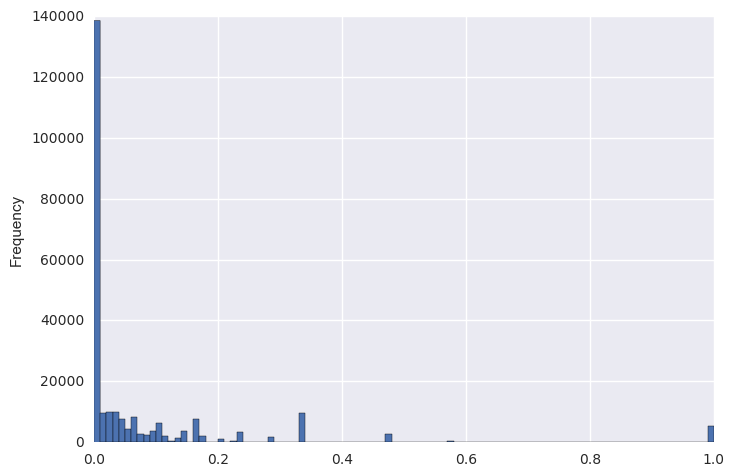

In [26]:
# plot what we got

clusters.plot.hist(bins=100)

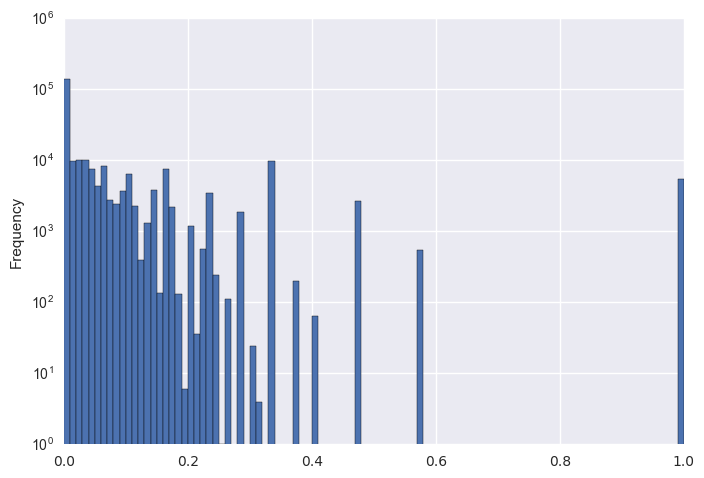

In [27]:
# hoping for a normal distribution, but not so much
# plot log-scaled, which is more normal, but skews

clusters.plot(kind='hist', bins=100, logy=True)

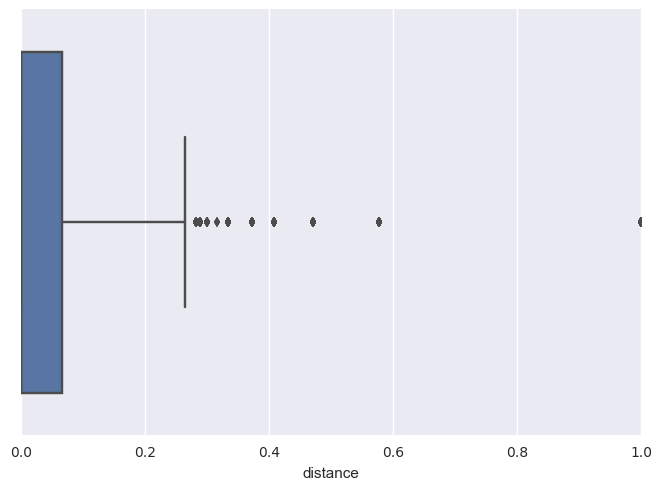

In [28]:
# plot boxplot to easily see if we have outliers....

import seaborn as sns

sns.boxplot(x=clusters, whis=3)

In [29]:
# calculate the cumulative sum, and 

cumulative_sums = clusters.cumsum()
total_sum = cumulative_sums.iloc[-1]

# todo - should compute percentage, not of some, but of data distribution
cut_99 = 0.99 * total_sum
cut_95 = 0.95 * total_sum

print "sum", total_sum, "\n99%", cut_99, "\n95%", cut_95

sum 18051.329455 
99% 17870.8161604 
95% 17148.7629822


In [30]:
# there are some codes which only show up once and will of course look like outliers...

# technically, they should equal one
THRESHOLD_SINGLE_CODE= 0.9999

# our threshold for outliers (should be by std deviations - TODO: compute)
THRESHOLD_OUTLIER = 0.35

single_code = clusters.ix[ clusters > THRESHOLD_SINGLE_CODE ]
print(str(len(single_code)) + ' rows have codes that only show up once')

5356 rows have codes that only show up once


In [31]:
# then, find the rows which are outliers without having a single code

outliers = clusters.ix[ (clusters > THRESHOLD_OUTLIER) & (clusters < THRESHOLD_SINGLE_CODE) ]
outliers = outliers.sort_values(ascending=False)

outliers[:10]

88924     0.57735
139978    0.57735
25961     0.57735
225511    0.57735
59168     0.57735
26382     0.57735
225199    0.57735
80143     0.57735
26640     0.57735
102783    0.57735
Name: distance, dtype: float64

In [32]:
# ok, now lets see what these codes actually are....
# weirdly very hard to find these codes, and ICD9 are different than HCPCS (I couldn't find anything)

# manually import, since not tab delimited
icd9_codes = pd.read_table(os.path.join(folder, "..", "ICD9_codes.txt"), names=['string'], header=None, low_memory=False)

icd9_codes = dict(zip(
    icd9_codes.string.map(lambda string: string.split(' ', 1)[0]),
    icd9_codes.string.map(lambda string: string.split(' ', 1)[1].strip())
    ))

In [33]:
# lets print what these outliers are

# many will print Unknown Code, since only ICD9 codes were available (not HCPCS), and incomplete list

for idx, score in outliers.iteritems():
    claim_id = outpatient_df.ix[idx, 'CLM_ID']
    codes = codebag[idx].split( )
    codes_text = ', '.join(codes)
    print("%s \t %5.4f \t %s" % (claim_id, score, codes_text))
    for code in codes:
        if code in icd9_codes:
            print(code + ' - ' + icd9_codes[code])
        else:
            print(code + " - (Unknown)")
    print("\n")


542482281573604 	 0.5774 	 71784, 85097, 51705
71784 - Old disruption of posterior cruciate ligament
85097 - (Unknown)
51705 - (Unknown)


542962281423171 	 0.5774 	 20933, 2392, 14041
20933 - Merkel cell carcinoma of the upper limb
2392 - Neoplasm of unspecified nature of bone, soft tissue, and skin
14041 - (Unknown)


542162280847207 	 0.5774 	 5937, 11100, S0028
5937 - (Unknown)
11100 - (Unknown)
S0028 - (Unknown)


542542281376290 	 0.5774 	 29543, 3129, V6285
29543 - Schizophreniform disorder, subchronic with acute exacerbation
3129 - Unspecified disturbance of conduct
V6285 - Homicidal ideation


542782281424142 	 0.5774 	 38840, 38910, 99204
38840 - Abnormal auditory perception, unspecified
38910 - Sensorineural hearing loss, unspecified
99204 - (Unknown)


542392281047967 	 0.5774 	 42654, 34590, 93279
42654 - Trifascicular block
34590 - Epilepsy, unspecified, without mention of intractable epilepsy
93279 - (Unknown)


542952281123375 	 0.5774 	 38501, 1121, 69210
38501 - Tympa

# Results

some examples of groups with manual lookup

- 71784 - Old disruption of posterior cruciate ligament
- 85097 - Bone Marrow Smear
- 51705 - Change of cystostomy tube; complicated


- V500 - Elective hair transplant for purposes other than remedying health states
- A9552 - Fluorodeoxyglucose f-18 fdg, diagnostic, per study dose, up to 45 millicuries
- A0429 - Ambulance service, basic life support, emergency transport (bls-emergency) ( Bls-emergency )


- 5937 - Under Pressure Ulcers (Decubitus Ulcers) Procedures
- 11100 - Shave Biopsy
- S0028 - Injection, famotidine, 20 mg


- Radiation oncology treatment delivery
- Moderate hypoxic-ischemic encephalopathy
- Kidney stone analysis with stone imaging


- Unspecified polyarthropathy or polyarthritis, other specified sites
- Closed Colles' fracture
- Nerve Conduction Studies 


# Takeaways 

Unclear how useful this model is.

Most of them seem fairly reasonable in this set.

More claims would be useful. This model relies on < 1% of all the records available, I just ran out of time building the scores. 

Takeaway: you should never copy algorithms off stack overflow without understanding how they work and how to optimize :(

# Things to look at later

- Look for:
    - unperformed services
    - unnecessary services
    - unbundling (separate procedures unnecessarily)
    - single patient ID billed across providers
    - upcoding 
    - routinely charging more than unit thresholds 